In [9]:
library(stats)
library(cluster)
install.packages('e1071')
library(e1071)
install.packages("adabag")
library("adabag")
install.packages("randomForest")
library("randomForest")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [10]:
#-------------------------------------------------------------------------------------
# AVISO: este codigo esta adaptado de un paquete mayor. 
# No es optimo y tiene cosas inutiles para nosotros. Es un ejemplo nada mas
#
#general forward greedy selection function
#input:
# x,y inputs and targets
# method is an external function that estimates classification error with a given model
# ... parameters for method
#output:
#ordered.names.list <- nombre de las variables ordenadas de la mas importante a la menos
#ordered.features.list <-numero de orden inicial de las variables, con el mismo orden
#importance <- importancia de cada variables en el mismo orden

#-------------------------------------------------------------------------------------
forward.ranking <- function(x,y,method,verbosity=0,... )
{

	max.feat<-dim(x)[2]
	num.feat<-1
	list.feat<-1:max.feat

	# ranking inicial: elijo la variable con menor error de prediccion
  x.train<-matrix(0,dim(x)[1],1)
	class.error<-double(max.feat)
	# para cada i, creo el dataset con esa variable sola, entreno un modelo
	# y le mido el error, que lo guardo en class.error[i]
	for(i in 1:max.feat){
		x.train[,1]<-x[,i]
		class.error[i] <- do.call(method, c(list(x.train, y), list(...)) )
	}
	# guardo la variable con minimo error como primera. Guardo una lista
	# keep.feat con las que me quedan para seguir eligiendo.
	list.feat[1]<-which.min(class.error)
	keep.feat<-sort(class.error,decreasing=FALSE,index=T)$ix[-1]
	#armo un dataset con las variables que ya elegi, para ir agregando en cada paso.
	x.prev<-x.train[,1]<-x[,list.feat[1]]

	if(verbosity>1) cat("\nFirst feature: ",list.feat[1],"\n")

  # loop principal. A cada paso agrego todas las variables disponibles,
	# de a una, le mido el error y me quedo con la de minimo error.
	# Hasta llegar a meter todas.
	while(num.feat<max.feat){
    # class.error guarda el error de cada modelo. Son max.feat-num.feat modelos.
		class.error<-double(max.feat-num.feat)
		# para cada variable que me queda, la agrego al dataset del paso anterior,
		# entreno el modelo y le mido el error.
		for(i in 1:(max.feat-num.feat)){
			x.train<-cbind(x.prev,x[,keep.feat[i]])
			class.error[i] <- do.call(method, c(list(x.train, y), list(...)) )
		}
		if(verbosity>2) cat("\nFeatures:\n",keep.feat,"\nErrors:\n",class.error)
		# me quedo con el modelo de minimo error, guardo ese feature en la lista
		# de las elegidas, lo saco de la lista de las que quedan, y actualizo
		# el dataset de partida de la iteracion.
		best.index<-which.min(class.error)
		list.feat[num.feat+1]<-keep.feat[best.index]
		if(verbosity>1) cat("\n---------\nStep ",1+num.feat,"\nFeature ",best.index)

		keep.feat<-keep.feat[-best.index]
		if(verbosity>2) cat("\nNew search list: ",keep.feat)
		num.feat<-num.feat+1
		x.prev<-x[,list.feat[1:num.feat]]
	}


	search.names<-colnames(x)[list.feat]
	# le asigno a cada feature una importacia proporcional al orden en que
	# lo seleccionamos
	imp<-(max.feat:1)/max.feat
	names(imp)<-search.names

	if(verbosity>1){
		cat("\n---------\nFinal ranking ",num.feat," features.")
		cat("\nFeatures: ",search.names,"\n")
	}

 	return( list(ordered.names.list=search.names,ordered.features.list=list.feat,importance=imp) )

}


#---------------------------------------------------------------------------
#random forest error estimation (OOB) for greedy search
#---------------------------------------------------------------------------
rf.est <- function(x.train,y,equalize.classes=TRUE,tot.trees=500,mtry=0)
{
	if(mtry<1) mtry<-floor(sqrt(dim(x.train)[2]))
	prop.samples<-table(y)
	if(equalize.classes) prop.samples<-rep(min(prop.samples),length(prop.samples))
	return( randomForest(x.train,y,mtry=mtry,ntree=tot.trees,sampsize=prop.samples)$err.rate[tot.trees] )
}

#---------------------------------------------------------------------------
#LDA error estimation (LOO) for greedy search
#---------------------------------------------------------------------------
lda.est <- function(x.train,y)
{
	m.lda <- lda(x.train,y,CV=TRUE)
	return(error.rate( y , m.lda$class))
}
error.rate <- function(dataA, dataB) sum( dataA != dataB ) / length(dataB)

#---------------------------------------------------------------------------
#SVM error estimation (internal CV) for greedy search
#---------------------------------------------------------------------------
svm.est <- function(x.train,y,type="C-svc",kernel="vanilladot",C=1,cross = 4)
{
	return ( ksvm(x.train, y, type=type,kernel=kernel,C=C,cross = cross)@cross )
}


#---------------------------------------------------------------------------
#random forest ranking method for rfe.
#---------------------------------------------------------------------------
imp.rf <- function(x.train,y,equalize.classes=TRUE,tot.trees=500,mtry=0)
{
	if(mtry<1) mtry<-floor(sqrt(dim(x.train)[2]))
	prop.samples<-table(y)
	if(equalize.classes) prop.samples<-rep(min(prop.samples),length(prop.samples))
	
	m.rf<-randomForest(x.train,y,ntree=tot.trees,mtry=mtry,sampsize=prop.samples,importance=TRUE)
	imp.mat<-importance(m.rf)
	imp.col<-dim(imp.mat)[2]-1
	rank.list<-sort(imp.mat[,imp.col],decreasing=FALSE,index=T)
	return(list(feats=rank.list$ix,imp=rank.list$x))
}


#---------------------------------------------------------------------------
#linear svm ranking method for rfe. Using kernlab. Multiclass
#---------------------------------------------------------------------------
imp.linsvm <- function(x.train,y,C=100)
{
	num.feat<-dim(x.train)[2]
	tot.problems<-nlevels(y)*(nlevels(y)-1)/2

	m.svm <- ksvm(as.matrix(x.train), y, type="C-svc",kernel="vanilladot",C=C)

	w<-rep(0.0,num.feat)
	for(i in 1:tot.problems) for(feat in 1:num.feat)
		w[feat]<-w[feat]+abs(m.svm@coef[[i]] %*% m.svm@xmatrix[[i]][,feat])
	rank.list<-sort(w,decreasing=FALSE,index=T)
	return(list(feats=rank.list$ix,imp=rank.list$x))
}


#filter con kruskal esta en las slides


install.packages("randomForest")
install.packages("kernlab")
library(randomForest)
library(kernlab)
library(MASS)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)


Attaching package: ‘kernlab’


The following object is masked from ‘package:ggplot2’:

    alpha




In [16]:
# ================================== BACKWARD ==================================
backward.ranking = function(x, y, method, ...) {
  max.feat = dim(x)[2]
	list.feat = 1:max.feat
  keep.feat = double(max.feat)

  while(length(list.feat) > 1){
		class.error = double(length(list.feat))

		# Para cada feature, entreno el modelo y le mido el error.
		for(i in 1:length(list.feat)){
			x.train = as.matrix(x[, list.feat[-i]])
			class.error[i] = do.call(method, c(list(x.train, y), list(...)) )
		}

		# Seleccionar el peor feature y lo saco de la lista.
		worst.feat = which.min(class.error)
		keep.feat[length(list.feat)] = list.feat[worst.feat]
		list.feat = list.feat[-worst.feat]
  }

	keep.feat[1] = list.feat

	search.names = colnames(x)[keep.feat]
	# Le asigno a cada feature una importacia proporcional al orden en que lo seleccionamos.
	imp = (max.feat:1)/max.feat
	names(imp) = search.names

 	return( list(ordered.names.list=search.names,ordered.features.list=keep.feat,importance=imp) )
}

# ================================= KRUSKAL ====================================
kruskal_wallis.ranking = function(x, y) {
  max.feat = dim(x)[2]
  rank.list = c()

  # Para cada feature, calculo su estadistico de kruskal wallis.
  for (i in 1:max.feat) rank.list[i] = kruskal.test(x[,i],y)$statistic

  # Ordeno los features por su estadistico de kruskal wallis.
  rank.list = sort(rank.list, decreasing=TRUE, index.return=TRUE)$ix

  search.names = colnames(x)[rank.list]
	# Le asigno a cada feature una importacia proporcional al orden en que lo seleccionamos.
	imp = (max.feat:1)/max.feat
	names(imp) = search.names

  return( list(ordered.names.list=search.names,ordered.features.list=rank.list,importance=imp) )
}

# ===================================== RFE ====================================
rfe.ranking = function(x, y, method, ...) {
  max.feat = dim(x)[2]
  rank.list = 1:max.feat
  list.feat = 1:max.feat

  for (i in 1:max.feat) {
    x.train = as.matrix(x[,list.feat])
    rank_ = do.call(method, c(list(x.train, y), list(...)) )
    last = rank_$feats[1]
    rank.list[max.feat - i + 1] = list.feat[last]
    list.feat = list.feat[-last]
  }

  search.names = colnames(x)[rank.list]
	# Le asigno a cada feature una importacia proporcional al orden en que lo seleccionamos.
	imp = (max.feat:1)/max.feat
	names(imp) = search.names

  return( list(ordered.names.list=search.names,ordered.features.list=rank.list,importance=imp) )
}

# ================================== PLOT DATA =================================
sort_info = function(list) {
  ord.names = c()
  ord.values = c()

  i = 1
  for (j in list$ordered.features.list) {
    ord.names[j] = list$ordered.names.list[i]
    ord.values[j] = list$importance[i]
    i = i + 1
  }

  return ( list(names=ord.names, values=ord.values) )
}

plotbar_values = function(list, title) {
  ord.info = sort_info(list)
  barplot(ord.info$values, names.arg=ord.info$names, main=title, las=2, col="cyan") 
}

In [12]:
# =============================== CLUSTER COMPARE ==============================
cluster_compare = function(default, cc) {
  #hago una tabla de confusion para comparar
  cont.table <- table(default,cc)
  print(cont.table)
  # Find optimal match between the two classifications
  class.match <- matchClasses(as.matrix(cont.table),method="exact")
  # Print the confusion table, with rows permuted to maximize the diagonal
  print(cont.table[,class.match])
}

# ================================ ESTABILIDAD =================================
estabilidad = function(data, K, r) {
    est.score = function(n, ind1, ind2, cc1, cc2) {
        #pongo los clusters de nuevo en longitud n - quedan 0 los puntos fuera del sample
        v1<-v2<-rep(0,n)
        v1[ind1]<-cc1
        v2[ind2]<-cc2
        #creo una matriz m con 1 donde los dos puntos estan en el mismo cluster, -1 en distinto cluster y 0 si alguno no esta, para cada
        # clustering
        a<-sqrt(v1%*%t(v1))
        m1<-a / -a + 2*(a==round(a))
        m1[is.nan(m1)]<-0
        a<-sqrt(v2%*%t(v2))
        m2<-a / -a + 2*(a==round(a))
        m2[is.nan(m2)]<-0
        #calculo el score, los pares de puntos que estan en la misma situacion en los dos clustering dividido el total de pares validos.
        validos<-sum(v1*v2>0)
        score<-sum((m1*m2)[upper.tri(m1)]>0)/(validos*(validos-1)/2)
        return (score)
    }

    n.row = nrow(data)
    r.samples.index = list()
    for (i in 1:r) {
        r.samples.index[[i]] = sample(n.row, n.row * .8)
    }

    k.scores = c()
    for (k in 2:K) {
        km.r.samples = list()
        for (i in 1:r) {
            km.r.samples[[i]] = kmeans(data[r.samples.index[[i]],], k, nstart=25)$cluster
        }
        
        scores = c()
        for (i in 1:(r-1)) {
            for (j in (i+1):r) {
                scores = c(scores, est.score(n.row, r.samples.index[[i]], r.samples.index[[j]], km.r.samples[[i]], km.r.samples[[j]]))
            }
        }

        k.scores = c(k.scores, mean(scores))
    }

    return (list(scores=k.scores, best.k=which.max(k.scores)+1))
}

In [12]:
# =============================== RANDOM FOREST ================================
rf.test = function(dataset, y) {
  n.vars = function(n) {
    # res = c(n)
    # cnt = n
    # while (floor(cnt / 2) > 0) {
    #   cnt = floor(cnt/2)
    #   res = c(res, cnt)
    # }
    # return (res)

    return(1:n)
  }

  rf.errors = c()
  n.cols = ncol(dataset) - 1
  for (n in n.vars(n.cols)) {
    n.error = c()
    for (r in 1:5) {
      rf = randomForest(y, data=dataset, mtry=n, ntree=1000)
      rf.error = mean(rf$confusion[,3])
      n.error = c(n.error, rf.error)
    }

    rf.errors = c(rf.errors, mean(n.error))
  }

  return (list(n.vars=n.vars(n.cols), rf.errors=rf.errors))
}

# Informacion del Dataset
Este es un dataset sobre musica. La idea es utilizarlo para predecir el genero de la cancion. A continuacion mencionamos las features que tiene el dataset.

- instance_id: unique ID for each music
- artist_name: artist name
- track_name: track name
- popularity: how popular of this music
- acousticness: acousticness
- danceability: danceability
- duration_ms: the duration of the music in ms
- energy: energy
- instrumentalness: instrumentalness
- key: music key
- liveness: liveness
- loudness: loudness
- mode: mode
- speechiness: speechiness
- tempo: tempo
- obtained_date: date
- valence: valence
- music_genre: genres are 'Electronic', 'Anime', 'Jazz', 'Alternative', 'Country', 'Rap', 'Blues', 'Rock', 'Classical', 'Hip-Hop'.

Realizamos un poco de limpieza de los datos. En algunas columnas como `duration_ms` tiene valores -1 por lo que esos datos los eliminamos. Tambien encontramos valores como `"?"` en la columna tempo y algunos `NA` que estos tambien los vamos a sacar del dataset.

Por ultimo, a los generos los tomamos como factors.

Este es link de dataset: https://www.kaggle.com/datasets/vicsuperman/prediction-of-music-genre

In [11]:
data = read.csv('/content/music_genre.csv')
data = na.omit(data)
data = data[-which(data$duration_ms == -1),]
data$tempo = as.double(data$tempo)
data$key = as.factor(data$key)
data$mode = as.factor(data$mode)
data = na.omit(data)
data$music_genre = as.factor(data$music_genre)
summary(data)

Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”


  instance_id    artist_name         track_name          popularity   
 Min.   :20002   Length:40560       Length:40560       Min.   : 0.00  
 1st Qu.:37995   Class :character   Class :character   1st Qu.:34.00  
 Median :55900   Mode  :character   Mode  :character   Median :45.00  
 Mean   :55875                                         Mean   :44.28  
 3rd Qu.:73818                                         3rd Qu.:56.00  
 Max.   :91759                                         Max.   :99.00  
                                                                      
  acousticness    danceability     duration_ms          energy        
 Min.   :0.000   Min.   :0.0596   Min.   :  15509   Min.   :0.000792  
 1st Qu.:0.020   1st Qu.:0.4420   1st Qu.: 190480   1st Qu.:0.433000  
 Median :0.144   Median :0.5690   Median : 227533   Median :0.644000  
 Mean   :0.306   Mean   :0.5584   Mean   : 245490   Mean   :0.600330  
 3rd Qu.:0.550   3rd Qu.:0.6870   3rd Qu.: 275760   3rd Qu.:0.817000  
 Max. 

In [3]:
summary(data$music_genre)

Alternative       Anime       Blues   Classical     Country  Electronic 
       4051        4064        4046        4036        4049        4032 
    Hip-Hop        Jazz         Rap        Rock 
       4077        4064        4042        4099

Como podemos ver, el dataset es bastante extenso, por lo que vamos a utilizar un sample de este.

Tambien hay que destacar que las features `instance_id`, `artist_name`, `track_name` y `obtained_date` no las vamos a utilizar durante el analisis del dataset ya que son datos que no nos dan informacion importante

In [13]:
vars = data[,-c(1,2,3,16)]
sf = sample(1:dim(vars)[1])
sf = sf[1:(length(sf)*.1)]
vars = vars[sf,]
summary(vars)

   popularity     acousticness       danceability     duration_ms     
 Min.   : 0.00   Min.   :0.000001   Min.   :0.0596   Min.   :  34067  
 1st Qu.:35.00   1st Qu.:0.018975   1st Qu.:0.4460   1st Qu.: 191019  
 Median :45.00   Median :0.141000   Median :0.5730   Median : 227687  
 Mean   :44.78   Mean   :0.304925   Mean   :0.5637   Mean   : 245099  
 3rd Qu.:56.00   3rd Qu.:0.552250   3rd Qu.:0.6953   3rd Qu.: 275650  
 Max.   :96.00   Max.   :0.996000   Max.   :0.9760   Max.   :4497994  
                                                                      
     energy         instrumentalness        key          liveness      
 Min.   :0.000792   Min.   :0.000000   G      : 483   Min.   :0.02120  
 1st Qu.:0.433750   1st Qu.:0.000000   C#     : 439   1st Qu.:0.09788  
 Median :0.641000   Median :0.000165   C      : 438   Median :0.12700  
 Mean   :0.601382   Mean   :0.180220   D      : 420   Mean   :0.19279  
 3rd Qu.:0.823000   3rd Qu.:0.141250   A      : 380   3rd Qu.:0.23725  


Con este grafico podemos ver que los datos estan bastante superpuestos, no hay claras diviciones entre los generos musicales y podemos decir que al momento de generar clasificadores, puede ser que no obtengamos buenos resultados.

Se puede destacar que la feature `loudness` parece separar bastante bien al genero de color azul claro y para mi puede que esta feature se importante al momento que haga analisis de variables.

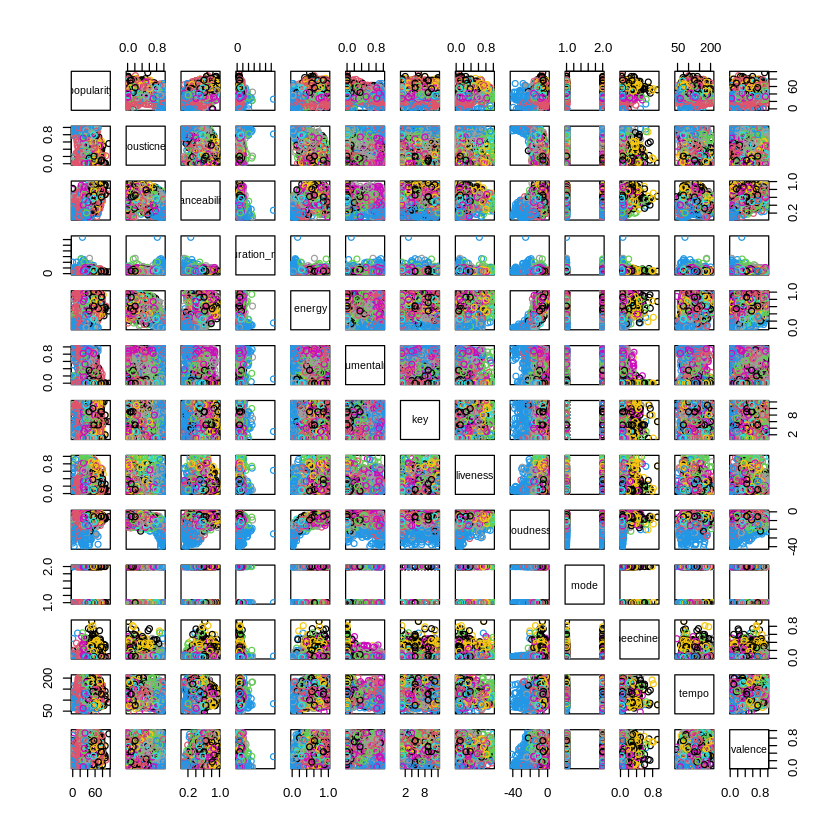

In [13]:
plot(vars[,-14], col=vars[,14])

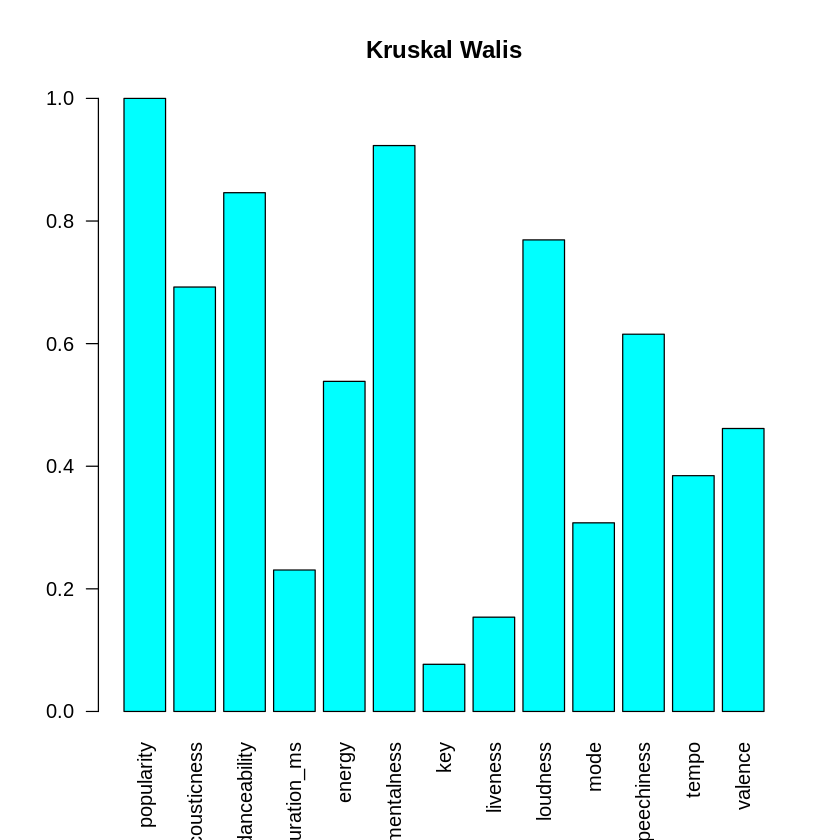

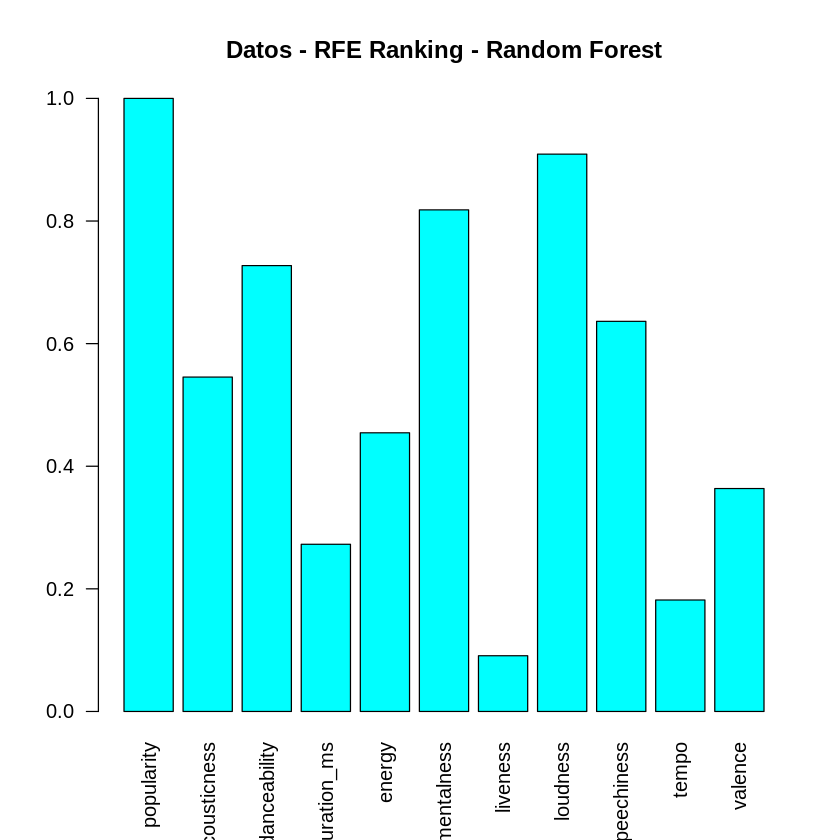

In [17]:
vars.kw = kruskal_wallis.ranking(vars[,-14], vars[,14])
plotbar_values(vars.kw, "Kruskal Walis")

vars.rr.rf = rfe.ranking(vars[,-c(7,10,14)], vars[,14], "imp.rf")
plotbar_values(vars.rr.rf, "Datos - RFE Ranking - Random Forest")

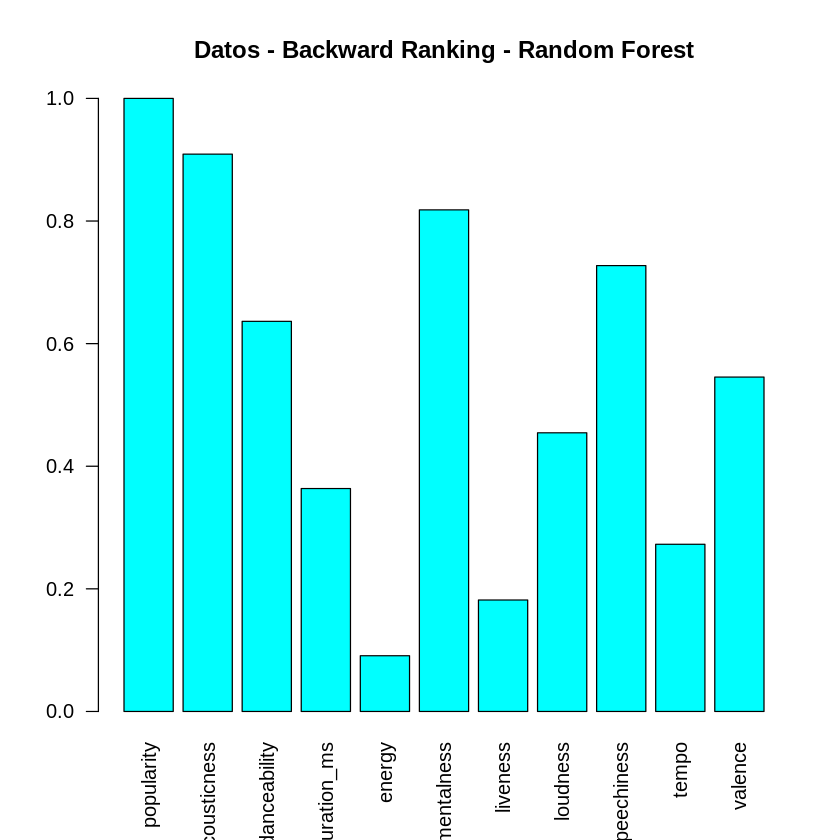

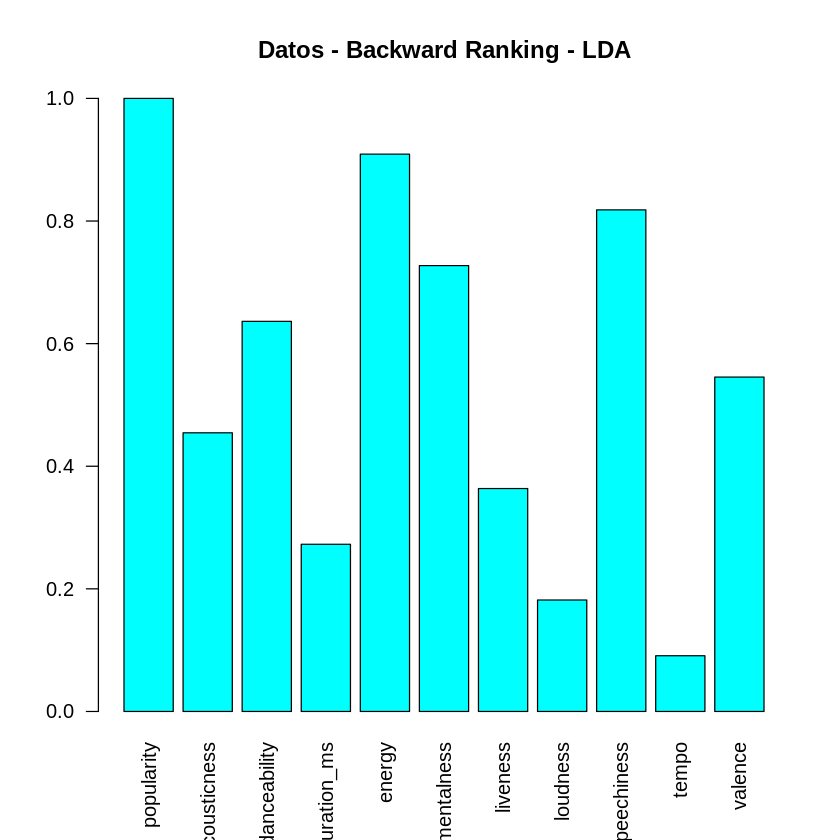

In [18]:
vars.br.rf = backward.ranking(vars[,-c(7,10,14)], vars[,14], "rf.est")
vars.br.lda = backward.ranking(vars[,-c(7,10,14)], vars[,14], "lda.est")

plotbar_values(vars.br.rf, "Datos - Backward Ranking - Random Forest")
plotbar_values(vars.br.lda, "Datos - Backward Ranking - LDA")

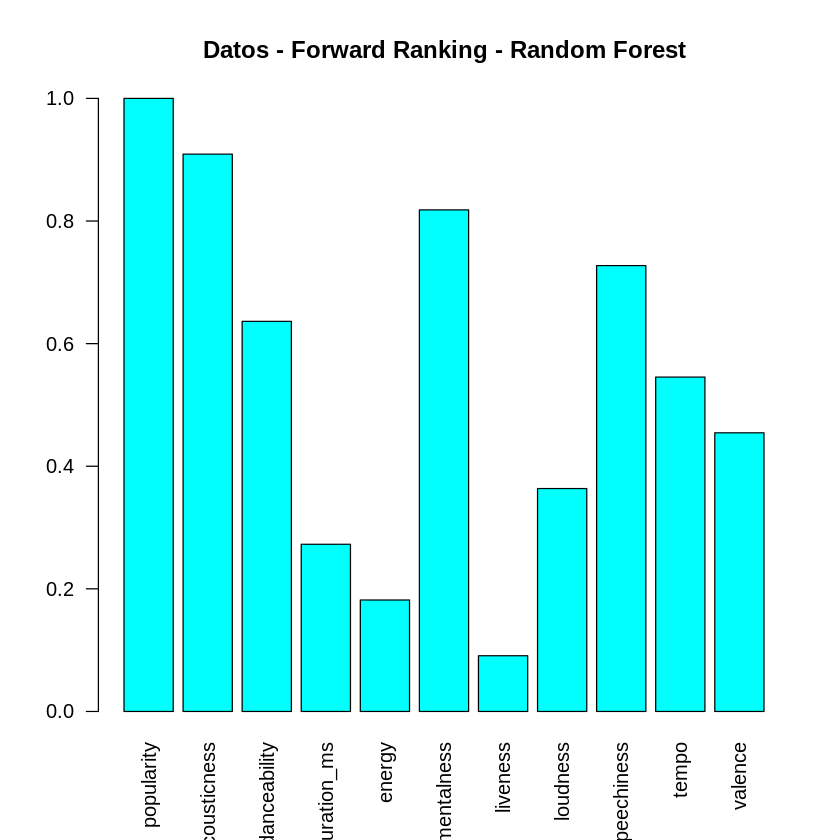

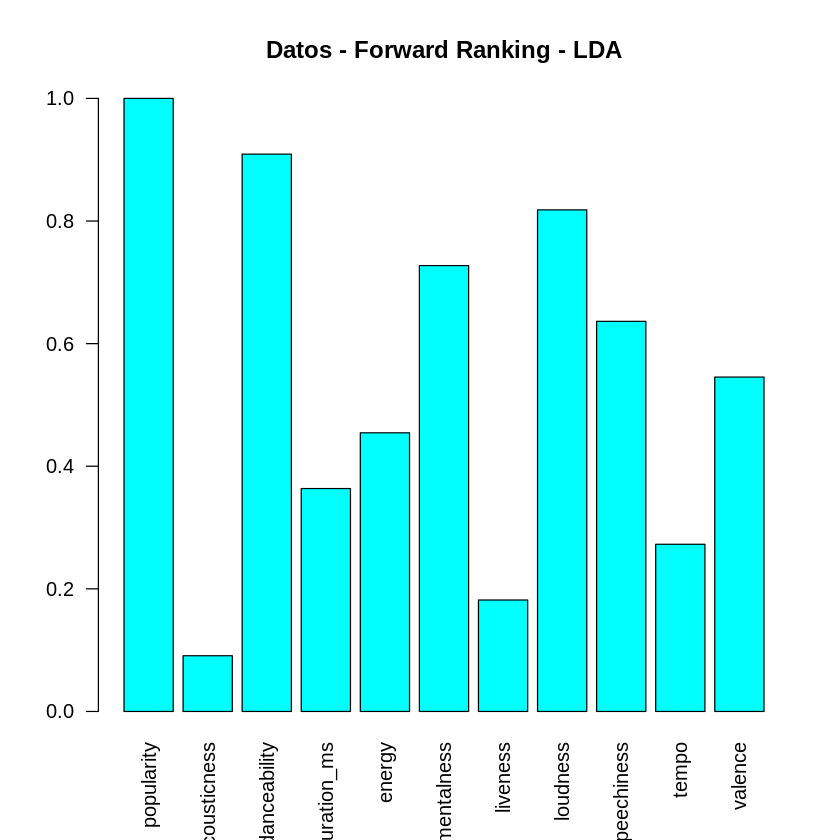

In [19]:
vars.fr.rf = forward.ranking(vars[,-c(7,10,14)], vars[,14], "rf.est")
vars.fr.lda = forward.ranking(vars[,-c(7,10,14)], vars[,14], "lda.est")

plotbar_values(vars.fr.rf, "Datos - Forward Ranking - Random Forest")
plotbar_values(vars.fr.lda, "Datos - Forward Ranking - LDA")

Despues de aplicar varios metodos de ranking de variables podemos concluir algunas cosas.

Las variables como `liveness` y `duration_ms` son variables que en todos los metodo obtuvieron un ranking bajo. Esto tiene sentido ya que las mayoria de las canciones suelen tener una duracion similar y no es que se puede decir que un genero suele tener canciones de mayor duracion.

Luego tambien podemos decir que la feature `loudness` siempre aparecio en el top 5 del ranking y es algo que se esperaba. Tambien hay variables como `popularity` que siempre la de mayor ranking y esta tiene sentido que sea importante.

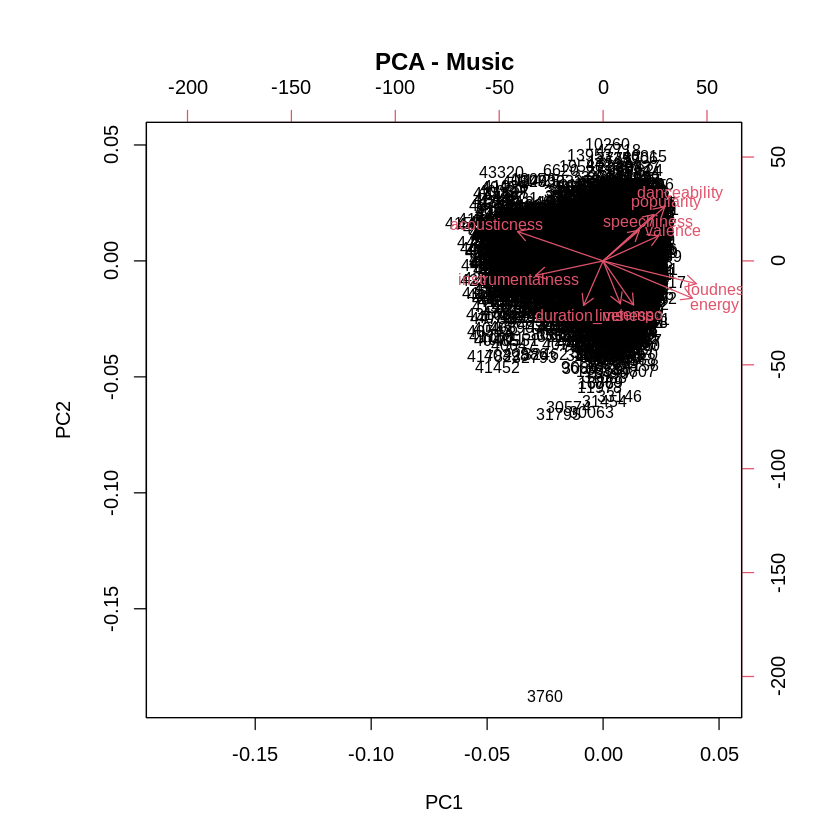

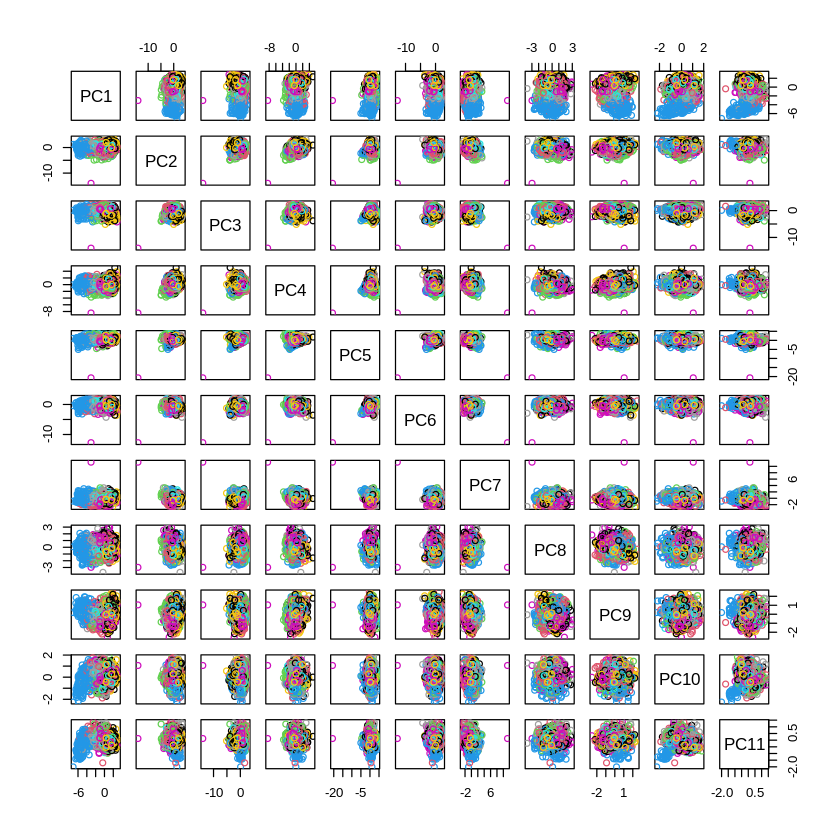

In [15]:
vars.pca = prcomp(vars[,-c(7,10,14)], scale=TRUE)
biplot(vars.pca, cex=0.8, main="PCA - Music")
plot(as.data.frame(vars.pca$x), col=vars[,14])

Despues de hacer el analisis de variables, me parecio mejor no utilizar las variables categoricas y tambien decidi sacar las variables con menor ranking (`liveness` y `duration_ms`)

In [15]:
vars.clusters = vars[,-c(4,5,7,8,10,12,14)]
km.vars = kmeans(vars.clusters, 10, nstart=25)
cluster_compare(vars[,14], km.vars$cluster)

             cc
default         1   2   3   4   5   6   7   8   9  10
  Alternative 207   0  58   2 108   9  31   0   2   0
  Anime        20 103   2   3   6   0  36  21 157  26
  Blues        55 149   9   5  19   1 114   3  31   3
  Classical    16  25   5 101   4   0  35 159   2  58
  Country     124   2  44   6  91  16 143   0   1   4
  Electronic   65 124  12   3  37   1 137   2  19   1
  Hip-Hop      35   0 138   0 166  71   3   0   0   0
  Jazz        105  46  12  49  34   1 129  14   3   5
  Rap          13   0 170   0 141  92   0   0   0   0
  Rock         15   1 151   2 162  79   0   0   1   1
Direct agreement: 2 of 10 pairs
Iterations for permutation matching: 40320 
Cases in matched pairs: 31.56 %
             cc
default         1   9   2   8   7  10   5   4   3   6
  Alternative 207   2   0   0  31   0 108   2  58   9
  Anime        20 157 103  21  36  26   6   3   2   0
  Blues        55  31 149   3 114   3  19   5   9   1
  Classical    16   2  25 159  35  58   4 101   5 

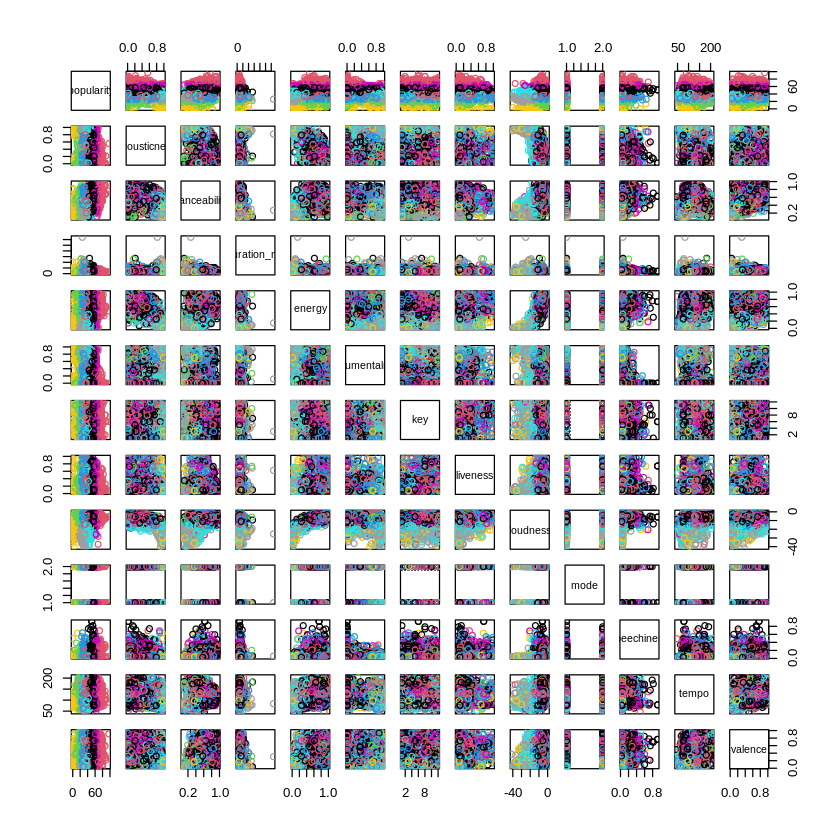

In [12]:
plot(vars[,-14], col=km.vars$cluster)

In [8]:
vars.pca2 = prcomp(vars.clusters, scale=TRUE)
km.vars.pca2 = kmeans(vars.pca2$x, 10, nstart=25)
cluster_compare(vars[,14], km.vars.pca2$cluster)

             cc
default         1   2   3   4   5   6   7   8   9  10
  Alternative   2  85  19   2  63  16 140  19  18  39
  Anime        53  11  48  13   0 194  38   2   3  12
  Blues         3  32  32  15   6 142  57   1  10  97
  Classical   279   1  12  98   0   7  26   0   2  14
  Country       0 114   2   4  39  62  72   9   2  98
  Electronic    5  24 151   2  38  66  65  23  24  10
  Hip-Hop       0  52   1   1 115   0  10 125  82   7
  Jazz         33  38 136  24   7  24  14  17   4 102
  Rap           0  57   1   0 133   0  25 119  75  13
  Rock          3 166  11   3  90   0 104   4   1  38
Direct agreement: 1 of 10 pairs
Iterations for permutation matching: 362880 
Cases in matched pairs: 32.54 %
             cc
default         7   6   9   1  10   3   8   4   5   2
  Alternative 140  16  18   2  39  19  19   2  63  85
  Anime        38 194   3  53  12  48   2  13   0  11
  Blues        57 142  10   3  97  32   1  15   6  32
  Classical    26   7   2 279  14  12   0  98   0

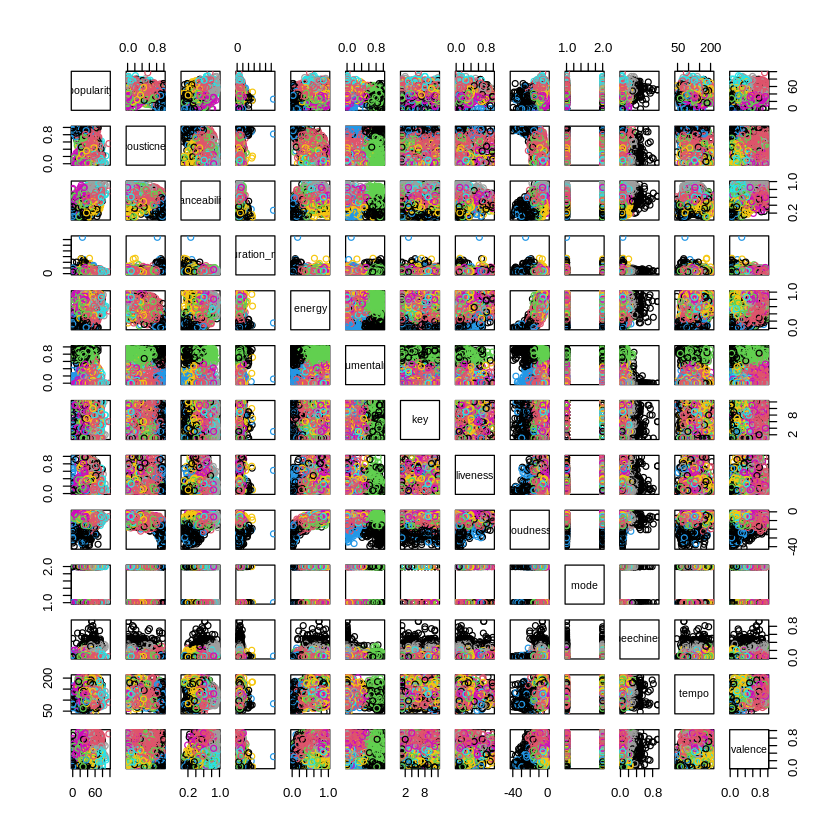

In [11]:
plot(vars[,-14], col=km.vars.pca2$cluster)

Como lo habia dicho antes, con este dataset, al tener las clases muy superpuestas, no vamos a obtener muy buenos resultados. Podemos ver que no hay mucha diferencia entre usar los datos en crudo y los datos aplicando PCA

In [9]:
hc.cc = hclust(dist(vars.clusters), method="average")
c.hc.cc = cutree(hc.cc, k=10)
cluster_compare(vars[,14], c.hc.cc)

             cc
default         1   2   3   4   5   6   7   8   9  10
  Alternative  38 361   0   0   0   3   1   0   0   0
  Anime       135  29 185   0   8   0  11   2   0   4
  Blues       281  67  33   0  10   0   0   4   0   0
  Classical   105  40  32  18 192   0   0  45   4   3
  Country     137 257   0   0   0   3   4   0   1   0
  Electronic  256 129  17   0   2   1   3   0   0   0
  Hip-Hop       2 362   0   0   0  29   0   0   0   0
  Jazz        230 151   5   0   8   0   2   0   3   0
  Rap           0 374   0   0   0  49   0   0   0   0
  Rock          2 379   0   0   0  38   0   0   1   0
Direct agreement: 2 of 10 pairs
Iterations for permutation matching: 40320 
Cases in matched pairs: 26.95 %
             cc
default         4   3   1   5   7   8  10   9   6   2
  Alternative   0   0  38   0   1   0   0   0   3 361
  Anime         0 185 135   8  11   2   4   0   0  29
  Blues         0  33 281  10   0   4   0   0   0  67
  Classical    18  32 105 192   0  45   3   4   0 

In [10]:
hc.cc = hclust(dist(vars.pca2$x), method="average")
c.hc.cc = cutree(hc.cc, k=10)
cluster_compare(vars[,14], c.hc.cc)

             cc
default         1   2   3   4   5   6   7   8   9  10
  Alternative 369  30   1   0   0   0   3   0   0   0
  Anime       253  53  61   0   7   0   0   0   0   0
  Blues       338  42  11   1   3   0   0   0   0   0
  Classical    58  25 347   2   7   0   0   0   0   0
  Country     395   2   5   0   0   0   0   0   0   0
  Electronic  250 153   4   0   0   0   0   1   0   0
  Hip-Hop     385   2   0   0   0   0   6   0   0   0
  Jazz        203 150  42   1   2   0   0   0   0   1
  Rap         415   1   0   0   0   0   6   0   1   0
  Rock        396  19   4   0   0   1   0   0   0   0
Direct agreement: 2 of 10 pairs
Iterations for permutation matching: 40320 
Cases in matched pairs: 22.95 %
             cc
default         8   5   4   3   9   2   7  10   1   6
  Alternative   0   0   0   1   0  30   3   0 369   0
  Anime         0   7   0  61   0  53   0   0 253   0
  Blues         0   3   1  11   0  42   0   0 338   0
  Classical     0   7   2 347   0  25   0   0  58 

Tambien decidi aplicar `hclust` para ver que tan bueno es un metodo de clustering jerarquico. En ambos casos, usando los datos crudo y los datos PCA los resultados fueron peor en comparacion a los resultados de `kmeans`.

In [21]:
estabilidad(vars.clusters, 20, 15)

Warning message:
“did not converge in 10 iterations”
Warning message:
“Quick-TRANSfer stage steps exceeded maximum (= 162200)”
Warning message:
“did not converge in 10 iterations”
Warning message:
“did not converge in 10 iterations”
Warning message:
“did not converge in 10 iterations”
Warning message:
“did not converge in 10 iterations”
Warning message:
“did not converge in 10 iterations”
Warning message:
“did not converge in 10 iterations”
Warning message:
“did not converge in 10 iterations”
Warning message:
“did not converge in 10 iterations”
Warning message:
“did not converge in 10 iterations”
Warning message:
“did not converge in 10 iterations”
Warning message:
“did not converge in 10 iterations”
Warning message:
“did not converge in 10 iterations”
Warning message:
“did not converge in 10 iterations”
Warning message:
“did not converge in 10 iterations”
Warning message:
“did not converge in 10 iterations”
Warning message:
“did not converge in 10 iterations”
Warning message:
“did not

$scores
 [1] 0.9843666 0.9868887 0.7822421 0.8694888 0.8680109 0.8178172 0.8412882
 [8] 0.8043426 0.7951111 0.8374651 0.8460789 0.8354261 0.8332493 0.8526755
[15] 0.8211802 0.8527501 0.8549109 0.8639696 0.8639093

$best.k
[1] 3

Buscamos la cantidad de cluster con el metodo de estabilidad y me sorprendió la poca cantidad de cluster que encontro, a continuacion podemos verlos en un grafico 

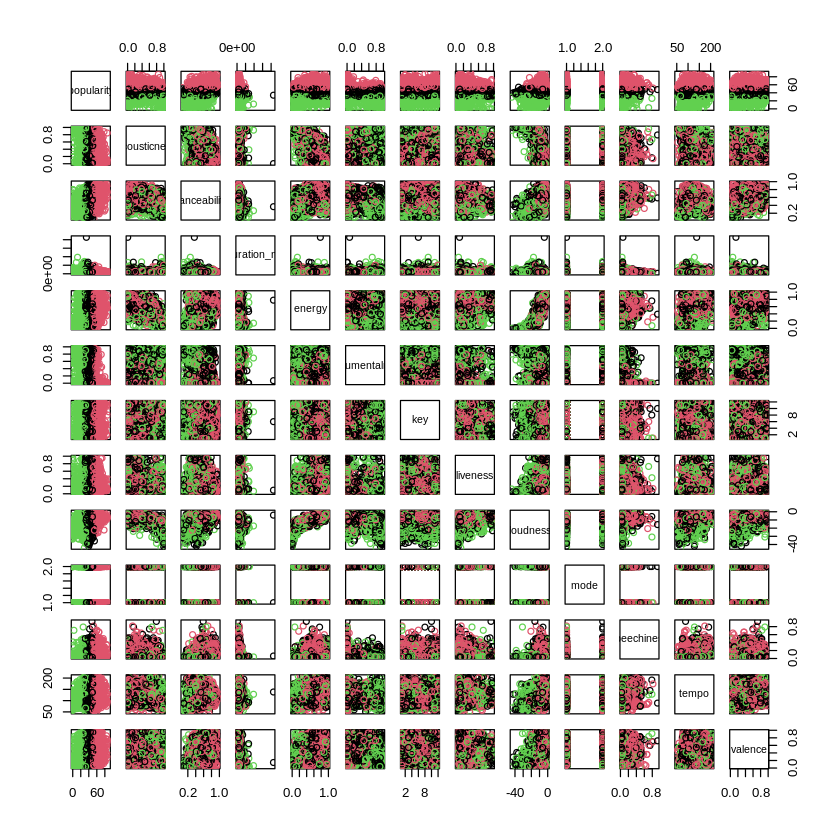

In [7]:
km3.vars = kmeans(vars.clusters, 3, nstart=25)
plot(vars[,-14], col=km3.vars$cluster)

$n.vars
 [1]  1  2  3  4  5  6  7  8  9 10 11 12 13

$rf.errors
 [1] 32.10 38.76 37.90 37.02 36.30 36.46 36.70 36.52 36.60 37.10 36.22 36.08
[13] 36.76

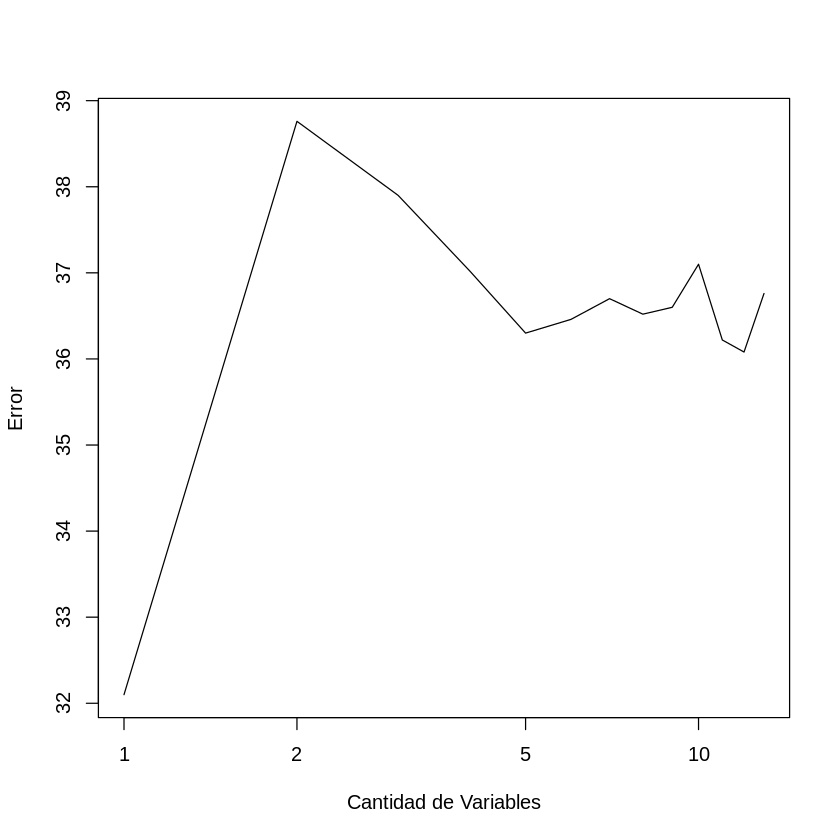

In [13]:
vars.df = vars[,-c(4,5,7,8,10,12)]
vars.rf = rf.test(vars, music_genre ~ .)
vars.rf
plot(vars.rf$n.vars, vars.rf$rf.errors, type="l", xlab="Cantidad de Variables", ylab="Error", log="x")

In [14]:
n.vars = 6
rf = randomForest(music_genre ~ ., data=vars, mtry=n.vars, ntree=1000)
rf.error = mean(rf$confusion[,3])
rf.error

[1] 35.5

Para el ejercicio de clasificacion, primero buscamos la cantidad de features para generar el `RF` y despues de correrlo varias veces (2 horas cada corrida) me quedo que la cantidad optima es `n = 6`. Podemos ver que el modelo nos queda con un error del 35.5% lo cual no es tan bueno.

In [54]:
train.sf = sample(1:dim(vars)[1])
train.sf = train.sf[1:(length(train.sf)*.8)]
train.df = vars[train.sf,]
train.df = train.df[,-c(4,5,7,8,10,12)]
test.df = vars[-train.sf,]
test.df = test.df[,-c(4,5,7,8,10,12)]

vars.svm = suppressWarnings(svm(music_genre ~., data=train.df, kernel="polynomial"))
vars.svm.pred = predict(vars.svm, test.df)
mean(vars.svm.pred != test.df$music_genre)

[1] 0.4815271

In [55]:
vars.svm = suppressWarnings(svm(music_genre ~., data=train.df, kernel="radial"))
vars.svm.pred = predict(vars.svm, test.df)
mean(vars.svm.pred != test.df$music_genre)

[1] 0.4470443

Genere otros modelos con kernels SVM, y podemos ver que ambos tienen malos resultados con este dataset. El modelo SVM RBF fue el que mejor resultado tuvo de ambos pero no se comprara con el resultado del RF, asique para este problema, el mejor modelo seria utilizar RF pero tampoco es recomendable esto ya que tiene un error bastante alto.


Para concluir con este trabajo, podemos decir que este dataset es bastante interesante y no nos lleva a buenos resultados. Se pudo analizar bien las variables y creo yo que llegue a buenas conclusiones ya que en algunas pruebas sacaba a las features como `loudness` y los resultados eran peores.

En clustering no llegamos a buenos resultados, tanto con `kmeans` y `hclust`

Y por ultimo en clasificacion, obtuvimos mejores resutados que clustering pero tampocos fueron tan buenos como esperaba, por lo que no recomendaria usar estos modelos para clasificar ;)